# Classifying Chest X-Ray Images (Pneumonia)
### Markowitz Working NB

Dataset from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [9]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

## Loading images from local folders

In [29]:
# Filepaths
train_dir = 'chest_xray/train'
validation_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/' 

In [30]:
# Check functionality and num images
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
train_normal_dir

'chest_xray/train/NORMAL'

In [31]:
print('There are', len(os.listdir(train_normal_dir)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia_dir)), 'pneumonia images in the training set')

There are 1341 normal images in the training set
There are 3875 pneumonia images in the training set


### EDA: Image Samples and Metadata

In [32]:
# Get list of filenames of all training images
train_norm_filenames = os.listdir(train_normal_dir)
train_pneum_filenames = os.listdir(train_pneumonia_dir)

In [33]:
# Make list of full filepaths to each image
train_normal_filepaths = [os.path.join(train_normal_dir, name) for name in train_norm_filenames]
train_pneumonia_filepaths = [os.path.join(train_pneumonia_dir, name) for name in train_pneum_filenames]

In [34]:
train_normal_filepaths[:10]

['chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0427-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0561-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1110-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0757-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1326-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-0736-0001.jpeg']

In [36]:
# Read each file in as an image
train_normal_images = [mpimg.imread(img) for img in train_normal_filepaths]
train_normal_images[0]

array([[ 0, 23, 24, ...,  0,  0,  0],
       [ 0,  5, 23, ...,  0,  0,  0],
       [ 1,  0, 26, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [37]:
def get_images(filepath):
    '''
    Given a filepath for a folder of images, return a list of those images
    as arrays of dtype=uint8.
    '''
    # List of filenames
    filenames = os.listdir(filepath)
    # List of full filepaths to each image
    filepaths = [os.path.join(filepath, name) for name in filenames]
    # Return list of files as raw image arrays
    return [mpimg.imread(img) for img in filepaths]

In [38]:
# Get training images of normal and pneumonia
train_normal_images = get_images(train_normal_dir)
train_pneumonia_images = get_images(train_pneumonia_dir)

#### Show the first 5 images from each set:

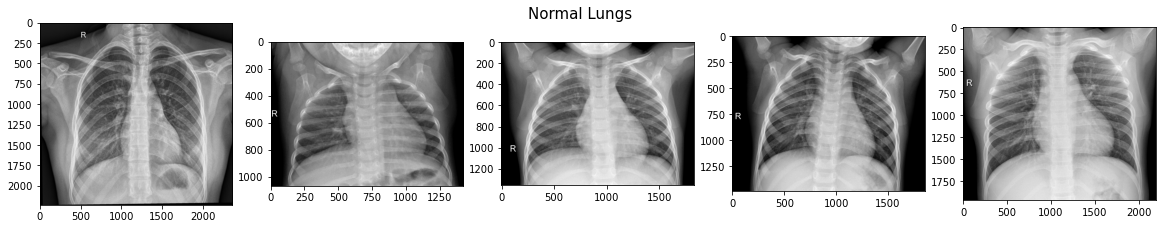

In [68]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_normal_images[i], cmap='gray')
fig.suptitle('Normal Lungs', fontsize=15, y=.8)
fig.tight_layout;

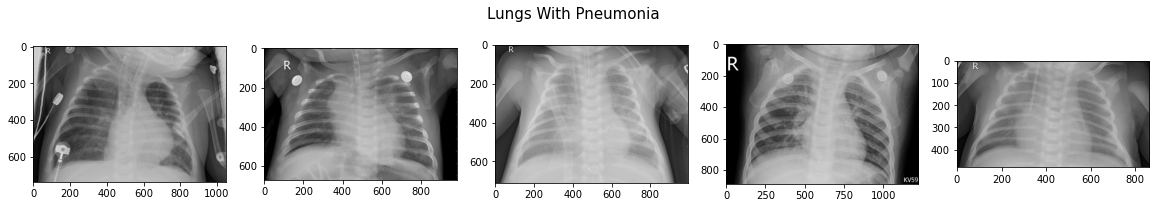

In [67]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_pneumonia_images[i], cmap='gray')
fig.suptitle('Lungs With Pneumonia', fontsize=15, y=.8)
fig.tight_layout;

**Notes:**
 - All photos are single-channel (black and white, not RGB)
 - All x-ray photos have 'R' to designate right-side lung
 - Pneumonia lungs have EKG(?) electrodes(?)--possible confounding factor for NN?
 - Pneumonia lungs look "cloudy" or "fuzzy" compared to Normal

From Kaggle:
> The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

Essentially, this means that bacterial pneumonia typically gathers in one area of the lungs, while viral penumonia is more spread out.

#### Metadata

In [84]:
# Dimensions of images
normal_img_shapes = [img.shape for img in train_normal_images]
pneumonia_img_shapes = [img.shape for img in train_pneumonia_images]

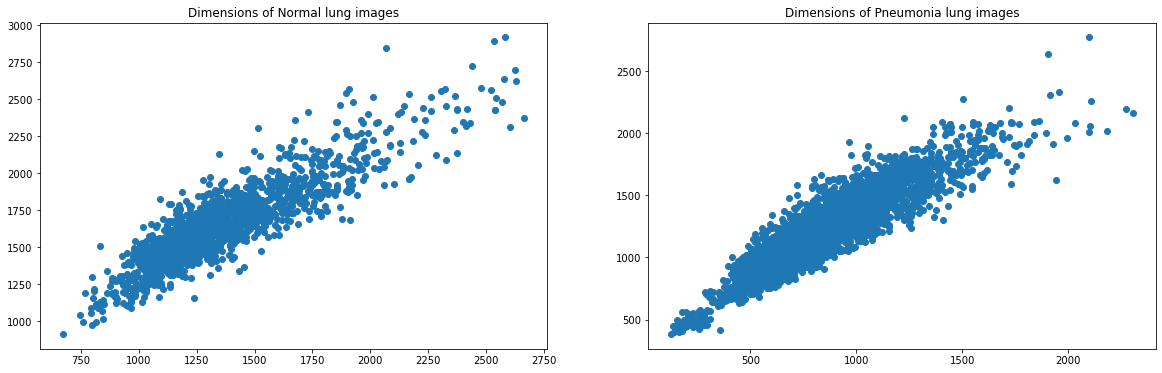

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Sizes of Normal lung images
ax1.scatter(x=[x[0] for x in normal_img_shapes], y=[x[1] for x in normal_img_shapes])
ax1.set_title('Dimensions of Normal lung images')

# Sizes of Pneumonia lung images
ax2.scatter(x=[x[0] for x in pneumonia_img_shapes], y=[x[1] for x in pneumonia_img_shapes])
ax2.set_title('Dimensions of Pneumonia lung images');

In [90]:
print('Smallest normal image dimension is ', np.min(normal_img_shapes))
print('Largest normal image dimension is ', np.max(normal_img_shapes))
print('Smallest pneumonia image dimension is ', np.min(pneumonia_img_shapes))
print('Largest pneumonia image dimension is ', np.max(pneumonia_img_shapes))

Smallest normal image dimension is  672
Largest normal image dimension is  2916
Smallest pneumonia image dimension is  (127, 384, 3)
Largest pneumonia image dimension is  (2304, 2160)


 - Overall linear relationships suggest similar aspect ratios, especially with smaller images (more variety with larger size images). 
 - Wild divergence in image size, though. The largest images are over 3x the size of the smallest images! How will this affect results/resizing? Does this mean we have to resize images to match the smallest image?
 - Pneumonia lung images have smaller sizes too (less than 500x500).

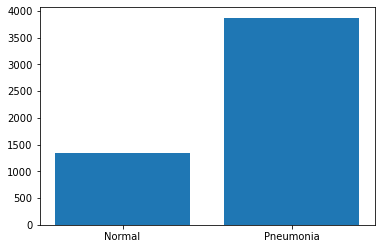

In [75]:
# Visualize class distribution in training data
plt.bar(x=['Normal', 'Pneumonia'], height=[len(train_normal_images), len(train_pneumonia_images)]);

Clearly not an even distribution! So many more pneumonia images, probably an over-representation.

## Loading images for modeling

We'll use the `ImageDataGenerator` class from Keras, as well as `flow_from_directory` to feed the images into the model.

In [93]:
# Get data from directories and reshape them

directory_kwargs = {'target_size':(100, 100),
                    'batch_size':50,
                    'color_mode':'grayscale',
                    'class_mode':'binary'}

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, **directory_kwargs)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir, **directory_kwargs)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **directory_kwargs)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [94]:
# Create the datasets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

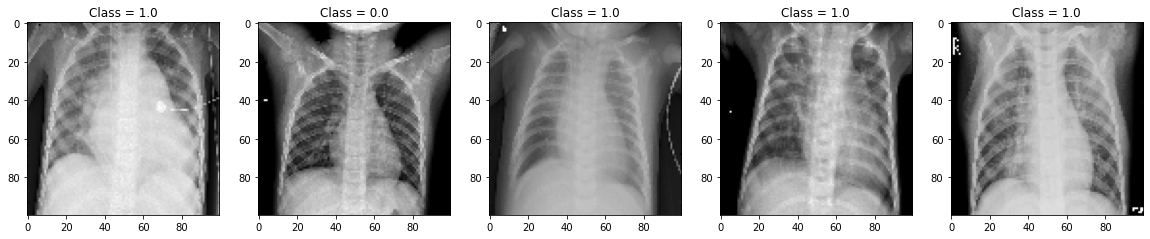

In [97]:
# Show the first 5 images in the training set
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(f'Class = {train_labels[i]}')

Note that all images have been resized to 100x100 pixels.

In [98]:
# Prepare images for modeling by reshaping
def reshape_images(images):
    return images.reshape(images.shape[0], -1)

In [99]:
X_train = reshape_images(train_images)
X_val = reshape_images(val_images)
X_test = reshape_images(test_images)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(50, 10000)
(16, 10000)
(50, 10000)


In [100]:
train_labels.shape

(50,)

## First Simple Model

Using simple fully connected Dense layers, no fancy stuff, no convolutions yet.

In [101]:
from keras import models
from keras.layers import Dense

In [116]:
# Instatiate model
model = models.Sequential()

# Add model layers
model.add(Dense(32, activation='relu', input_shape=(10000,)))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc', 'Recall'])

In [117]:
# Train the model
history = model.fit(X_train, train_labels, 
                    epochs=50,
                    batch_size=10,
                    validation_data=(X_val, val_labels))

Epoch 1/50
5/5 [==============================] - 0s 53ms/step - loss: 0.6432 - acc: 0.5800 - recall: 0.7368 - val_loss: 0.7652 - val_acc: 0.5000 - val_recall: 1.0000
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5655 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.8026 - val_acc: 0.5000 - val_recall: 1.0000
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 0.5457 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.7715 - val_acc: 0.5000 - val_recall: 1.0000
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 0.5352 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.8534 - val_acc: 0.5000 - val_recall: 1.0000
Epoch 5/50
5/5 [==============================] - 0s 8ms/step - loss: 0.5364 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.8541 - val_acc: 0.5000 - val_recall: 1.0000
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5327 - acc: 0.7600 - recall: 1.0000 - val_loss: 0.8595 - val_acc: 0.5000 - val_recall: 1.0000
Epo

5/5 [==============================] - 0s 8ms/step - loss: 0.2336 - acc: 0.9200 - recall: 1.0000 - val_loss: 0.8130 - val_acc: 0.5625 - val_recall: 1.0000


In [216]:
def visualize_training_results(results, model=None, X_train=None, train_labels=None, X_val=None, val_labels=None):
    '''
    Plot the training and validation data from a trained NN model, given the results/history.
    Plot accuracy, recall, and loss.
    
    If model and data are provided, print evaluation of training and validation data
    and plot confusion matrix.
    '''
    # Training history
    history = results.history
    
    # Accuracy
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['Validation acc', 'Training acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    # Recall
    plt.figure()
    plt.plot(history['val_recall'])
    plt.plot(history['recall'])
    plt.legend(['Validation recall', 'Training recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()
    
    # Loss
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['Validation loss', 'Training loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Evaluation
    if model and X_train.any() and train_labels.any():
        print('Training eval:')
        results_train = model.evaluate(X_train, train_labels)
    if X_val.any() and val_labels.any():
        print('\nValidation eval:')
        results_val = model.evaluate(X_val, val_labels)
        
    # Confusion matrix
    if model and X_train.any() and train_labels.any():
        y_preds = (model.predict(X_train) > 0.5).astype('int32')
        ConfusionMatrixDisplay(confusion_matrix(train_labels, y_preds), 
                           display_labels=['Normal', 'Pneumonia']).plot();

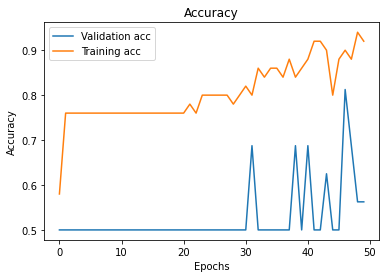

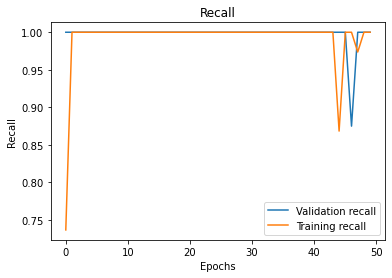

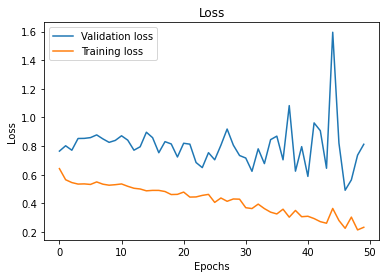

In [202]:
visualize_training_results(history)

In [120]:
results_train = model.evaluate(X_train, train_labels)

2/2 [==============================] - 0s 2ms/step - loss: 0.2251 - acc: 0.8800 - recall: 1.0000


In [121]:
results_val = model.evaluate(X_val, val_labels)

1/1 [==============================] - 0s 2ms/step - loss: 0.8130 - acc: 0.5625 - recall: 1.0000


Let's get a confusion matrix on this thing.

In [144]:
y_preds = (model.predict(X_train) > 0.5).astype('int32')

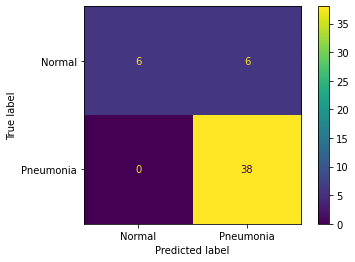

In [145]:
ConfusionMatrixDisplay(confusion_matrix(train_labels, y_preds), 
                       display_labels=['Normal', 'Pneumonia']).plot();

**Analysis:**
Our FSM runs! Huzzah! However, the accuracy and loss are all over the place and overall poor, likely because:
 - we are only training it on 50 images
 - loss of data from resizing the images down to 150x150
 - class imbalance (in favor of Pneumonia lungs)

In [110]:
model.save('first-simple-model.h5')

## Iterating

Our model can definitely improve! The overfitting is likely due to way too few images being used in training, combined with a serious class imbalance in favor of the target class. Also, our model is very basic (only 1 hidden layer), so adding a 2nd hidden layer will likely help.

In [193]:
def preprocess_dense_data(train_dir=train_dir, 
                          val_dir=validation_dir, 
                          test_dir=test_dir, 
                          process_test=False,
                          target_size=(256, 256),
                          batch_size=100,
                          color_mode='grayscale',
                          class_mode='binary'):
    '''
    Prepare image data for fitting in a fully connected dense neural network by
    getting data from directories, scaling, and reshaping
    
    Parameters: directories for training, validation, and testing data.
    
    Returns: X_train, X_val, X_test, train_labels, val_labels, test_labels
    '''
    # Param-dict for 'flow_from_directory'
    directory_kwargs = {'target_size':target_size,
                    'batch_size':batch_size,
                    'color_mode':color_mode,
                    'class_mode':class_mode}
    
    # Get data from directories and scale
    train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, **directory_kwargs)

    val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir, **directory_kwargs)
    
    if test_dir:
        test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **directory_kwargs)
    
    # Create the datasets
    train_images, train_labels = next(train_generator)
    val_images, val_labels = next(val_generator)
    if process_test:
        test_images, test_labels = next(test_generator)
    
    # Prepare images for modeling by reshaping
    def reshape_images(images):
        return images.reshape(images.shape[0], -1)
    
    X_train = reshape_images(train_images)
    X_val = reshape_images(val_images)
    if process_test:
        X_test = reshape_images(test_images)
        return X_train, X_val, X_test, train_labels, val_labels, test_labels
    else:
        return X_train, X_val, train_labels, val_labels

In [194]:
i1_X_train, i1_X_val, i1_X_test, i1_train_labels, i1_val_labels, i1_test_labels = preprocess_dense_data(process_test=True)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### i1 (iteration one):
 - Bump up size of images to 256x256
 - Increase number of images to 100
 - Add a 2nd hidden layer

In [167]:
# Instatiate model
i1_model = models.Sequential()

# Add model layers - Let's add another hidden layer this time
i1_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i1_model.add(Dense(16, activation='relu'))
i1_model.add(Dense(1, activation='sigmoid'))

# Compile
i1_model.compile(optimizer='sgd',
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

In [168]:
# Train the model
i1_history = i1_model.fit(i1_X_train, i1_train_labels, 
                    epochs=50,
                    batch_size=10,
                    validation_data=(i1_X_val, i1_val_labels))

Epoch 1/50
10/10 [==============================] - 0s 32ms/step - loss: 1.1534 - acc: 0.6400 - recall: 0.7436 - val_loss: 1.2325 - val_acc: 0.5000 - val_recall: 1.0000
Epoch 2/50
10/10 [==============================] - 0s 9ms/step - loss: 0.5620 - acc: 0.7800 - recall: 1.0000 - val_loss: 1.0820 - val_acc: 0.5000 - val_recall: 1.0000
Epoch 3/50
10/10 [==============================] - 0s 9ms/step - loss: 0.5298 - acc: 0.7800 - recall: 1.0000 - val_loss: 0.7669 - val_acc: 0.5000 - val_recall: 1.0000
Epoch 4/50
10/10 [==============================] - 0s 10ms/step - loss: 0.5311 - acc: 0.7800 - recall: 1.0000 - val_loss: 0.8629 - val_acc: 0.5000 - val_recall: 1.0000
Epoch 5/50
10/10 [==============================] - 0s 8ms/step - loss: 0.4831 - acc: 0.7800 - recall: 1.0000 - val_loss: 0.7997 - val_acc: 0.5000 - val_recall: 1.0000
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 0.4391 - acc: 0.7800 - recall: 1.0000 - val_loss: 0.7204 - val_acc: 0.5000 - val_reca

10/10 [==============================] - 0s 9ms/step - loss: 0.2810 - acc: 0.9000 - recall: 0.9487 - val_loss: 1.4935 - val_acc: 0.6250 - val_recall: 1.0000
Epoch 50/50
10/10 [==============================] - 0s 9ms/step - loss: 0.2130 - acc: 0.9500 - recall: 1.0000 - val_loss: 0.6195 - val_acc: 0.7500 - val_recall: 0.8750


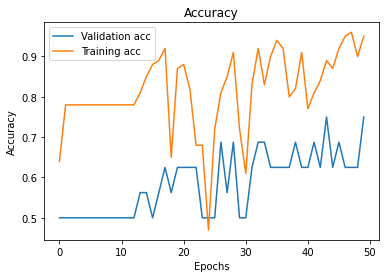

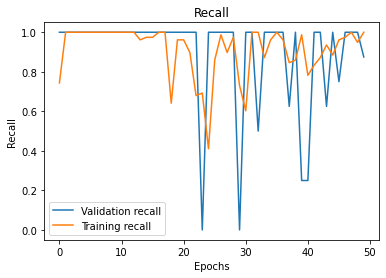

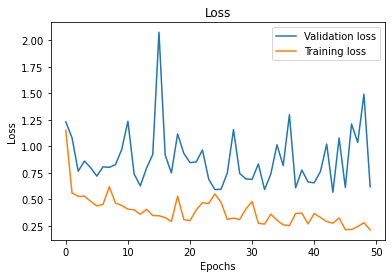

In [169]:
visualize_training_results(i1_history)

In [170]:
i1_model.evaluate(i1_X_train, i1_train_labels)

4/4 [==============================] - 0s 4ms/step - loss: 0.2079 - acc: 0.9800 - recall: 0.9744


[0.20792657136917114, 0.9800000190734863, 0.9743589758872986]

In [171]:
i1_model.evaluate(i1_X_val, i1_val_labels)

1/1 [==============================] - 0s 2ms/step - loss: 0.6195 - acc: 0.7500 - recall: 0.8750


[0.6194890737533569, 0.75, 0.875]

Definite improvement! The accuracies are now 98% / 75%, with recall also very high. Let's continue to bump up the number of training images used, plus take care of that class imbalance issue.

In [174]:
model.save('i1_model.h5')

### i2 (iteration two):
 - Include `class_weight` parameter during model fitting/training
 - Increase number of images to 500
 - Add a 3nd hidden layer

In [172]:
i2_X_train, i2_X_val, i2_X_test, i2_train_labels, i2_val_labels, i2_test_labels = preprocess_dense_data(batch_size=500)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [179]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [180]:
# From https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
from sklearn.utils import class_weight

# Calculate floats/raw class weights
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

# Convert to dict for .fit(class_weight= ) param
nn_class_weights = {0:class_weights[0],
                    1:class_weights[1]}

In [181]:
nn_class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [175]:
# Instatiate model
i2_model = models.Sequential()

# Add model layers - Same as previous model
i2_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i2_model.add(Dense(16, activation='relu'))
i2_model.add(Dense(1, activation='sigmoid'))

# Compile
i2_model.compile(optimizer='sgd',
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

In [182]:
# Train the model - This time incorporating class_weights
i2_history = i2_model.fit(i2_X_train, i2_train_labels, 
                          epochs=50,
                          batch_size=10,
                          class_weight=nn_class_weights,
                          validation_data=(i2_X_val, i2_val_labels))

Epoch 1/50
50/50 [==============================] - 1s 13ms/step - loss: 1.0085 - acc: 0.5040 - recall: 0.4626 - val_loss: 0.6448 - val_acc: 0.7500 - val_recall: 0.6250
Epoch 2/50
50/50 [==============================] - 0s 8ms/step - loss: 0.6876 - acc: 0.5400 - recall: 0.4792 - val_loss: 0.5935 - val_acc: 0.8125 - val_recall: 0.7500
Epoch 3/50
50/50 [==============================] - 0s 8ms/step - loss: 0.6835 - acc: 0.5040 - recall: 0.3573 - val_loss: 0.6247 - val_acc: 0.6250 - val_recall: 0.3750
Epoch 4/50
50/50 [==============================] - 0s 8ms/step - loss: 0.6390 - acc: 0.6760 - recall: 0.6620 - val_loss: 0.6268 - val_acc: 0.8125 - val_recall: 1.0000
Epoch 5/50
50/50 [==============================] - 0s 10ms/step - loss: 0.5358 - acc: 0.7540 - recall: 0.7147 - val_loss: 0.6594 - val_acc: 0.6250 - val_recall: 1.0000
Epoch 6/50
50/50 [==============================] - 0s 8ms/step - loss: 0.4730 - acc: 0.8080 - recall: 0.7922 - val_loss: 0.5416 - val_acc: 0.6250 - val_recal

50/50 [==============================] - 0s 7ms/step - loss: 0.2713 - acc: 0.8900 - recall: 0.8615 - val_loss: 0.4557 - val_acc: 0.8750 - val_recall: 1.0000
Epoch 50/50
50/50 [==============================] - 0s 7ms/step - loss: 0.2213 - acc: 0.8800 - recall: 0.8476 - val_loss: 0.3052 - val_acc: 0.9375 - val_recall: 1.0000


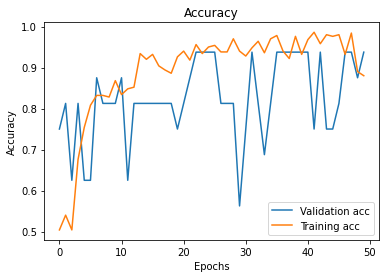

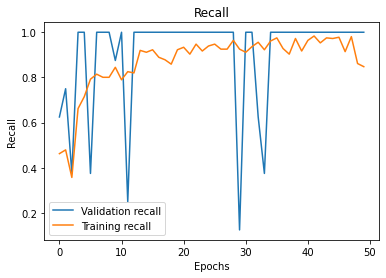

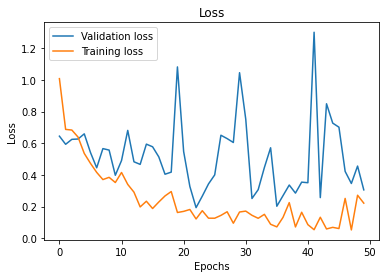

Training eval:
16/16 [==============================] - 0s 5ms/step - loss: 0.0749 - acc: 0.9680 - recall: 0.9584

Validation eval:
1/1 [==============================] - 0s 997us/step - loss: 0.3052 - acc: 0.9375 - recall: 1.0000


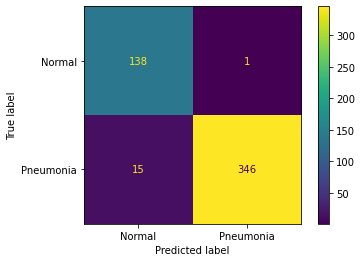

In [217]:
visualize_training_results(i2_history, i2_model, i2_X_train, i2_train_labels, i2_X_val, i2_val_labels)

In [218]:
model.save('i2_model.h5')

Another improvement! Adding the `class_weight` parameter helped close the gap between training and validation data and increased overall accuracy.